# Requirements

This section contains the necessary libraries and functions that will be used. It must be executed so that there are no errors later.

If you already have the libraries on your computer, you do not need to install them again.

## Libraries - Install

In [ ]:
!pip install scikit-maad
!pip install pydub
!pip install noisereduce
!pip install opensoundscape

## Libraries - Import

In [ ]:
#sistema
import os
import glob
import os.path
from pathlib import Path

#manejo audios
from pydub import AudioSegment
import librosa
import maad
from scipy import signal
import random
import soundfile as sf
from scipy.io import wavfile
import noisereduce as nr

#maad
from maad import sound, rois, features
from maad.util import (power2dB, plot2d, format_features, read_audacity_annot,
                       overlay_rois, overlay_centroid)
from maad import sound, util

#opensoundfile
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram


#manejo de dataframes
import numpy as np
import pandas as pd

#contar tiempo
import time

#graficos
import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline
from matplotlib.pyplot import figure

#para almacenar variables, modelos
import pickle

#para las barras de progreso
from tqdm import tqdm

## Functions

### save_model

In [ ]:
def save_model(model, path_save):
  """
  permite guardar un modelo pkl

  model: el modelo que se quiere guardar

  path_model: es la ruta donde se guardará el archivo. Recuerde escribir el nombre del archivo y su extensión
  (e.g. /content/drive/MyDrive/Modelos_TesisMaster/PKL/denoise_audios.pkl )

  """
  s_file = open(path_save, "wb") #creo un archivo para escribir
  pickle.dump(model, s_file) # escribo sobre el archivo
  s_file.close() #lo cierro

### load_model

In [ ]:
def load_model(path_model):
  """
  permite cargar un modelo pkl

  path_model: es la ruta de acceso del modelo

  esta funcion se debe asignar a una variable para que el modelo quede guardado ahi
  """

  l_file = open(path_model, "rb") #aqui lo leo
  model = pickle.load(l_file) #lo asigno a una variable
  l_file.close() #lo cierro

  return model

### bb_intersection_over_union_v3

In [ ]:
def bb_intersection_over_union_v3(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

### ROIS_comparation

In [ ]:
def ROIS_comparation(base,audio):
  """
  base: necesita un diccionario que contenga las keys 'auto_maad' y 'manual' para cada de los audios.
  ademas, dentro de cada key debe haber un dataframe con la ubicacion espacial de cada punto del rectagulo

  audio: el id del audio que se quiere plotear

  """
  s=audios_procesados[audio]
  fs=16000
  dB_max = 96

  Sxx_power, tn, fn, ext = sound.spectrogram(s, fs, nperseg=1024, noverlap=1024//2)
  Sxx_db = power2dB(Sxx_power) + dB_max

  df_rois_auto = base[audio]['auto_maad']

  df_rois_manual = base[audio]['manual']


  ax0, fig0 = overlay_rois(Sxx_db, df_rois_auto, title='ROI_AUTO', **{'vmin':0, 'vmax':dB_max, 'extent':ext})
  ax0, fig0 = overlay_rois(Sxx_db, df_rois_manual,title='ROI_MANUAL', **{'vmin':0, 'vmax':dB_max, 'extent':ext})

# Set Paths

Here are the paths to the different directories and the main database

In [ ]:
path_audios=r"/content/drive/MyDrive/Modelos_TesisMaster/Tracks/Troglodytes_aedon_wav"
sheet_url="https://docs.google.com/spreadsheets/d/1LRPPIK4s1Y76FaUM56KfvntLMRpY7wrJ_eUcB2o64bA/edit#gid=1339627192"
url=sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
path_csv=r'/content/drive/MyDrive/Modelos_TesisMaster/Dataframes/'
path_pkl=r'/content/drive/MyDrive/Modelos_TesisMaster/PKL/'

In [ ]:
database_audios=pd.read_csv(url) #base de datos
audios=glob.glob(path_audios+"/*")
audios.sort #rutas a cada audio ordenadas alfabeticamente

<function list.sort(*, key=None, reverse=False)>

In [ ]:
list_keys=list(database_audios.id_XC.value_counts().index) # id de los tracks de audio

# Load Models

In this section are the models that must be loaded (optional) so as not to execute all the code again

In [ ]:
#audios procesados a 16k -todos 637
audios_procesados=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/denoise_audios.pkl")

#datos para validacion de modelo maad - ovalle
ovalle_slices=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/ovalle_slices.pkl")

#cargo el diccionario con todos los ROIS convertidos a px
#este es el mismo que ovalle_slices pero cometí el error de cambiar el nombre y ahora todo está con este nombre
#luego segí editando sobre este y por eso se deben cargar ambos para evitar errores
ovalle_slices_px_manual_auto=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/ovalle_slices_px_manual_auto.pkl")

#diccionario con los tiempos de corte de los 458 tracks que quedaron despues de filtar por canto/llamado
#ya vienen con la columna de conversion a px por si se quiere plotear la caja
#se utilizó el conjunto de cantos a 16k dado que no se encontró diferencia entre los ROIS a 16k y 44k
first_slices_all=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/first_slices_all.pkl")

#estos son los recortes de audios subidos a 16k
audios_recortados=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/audios_recortados.pkl")

#audios procesados y recortados a 44k
audios_recortados44k=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/audios_recortados44k.pkl")

#espectrogramas(imagenes)
spectrogramas44k=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/spectrogramas44k.pkl")

# Preprocessing

In this section, the following procedures are performed on the audios:

- Noise reduction
- Stereo to mono
- Sample rate=16Khz

In [ ]:
#limpieza de ruido
start=time.time()

path_denoise_audios=r"/content/drive/MyDrive/Modelos_TesisMaster/PKL/denoise_audios.pkl"

sample_rate = 16000

audios_procesados={}


for i in tqdm(list_keys, desc='Progress'):
  x=r"/content/drive/MyDrive/Modelos_TesisMaster/Tracks/Troglodytes_aedon_wav/"+i+"_Troglodytes_aedon.wav"
  s, fs = librosa.load(x, mono=True, sr=sample_rate, offset=0) #con esto ya queda remuestreado a 16k y convertido en mono
  s_filter = maad.sound.select_bandwidth(s,fs,fcut=(2000,7000), forder=5, fname ='butter', ftype='bandpass') # filtro para eliminar frecuencias y dejar solo desde 2KHz a 7KHz
  s_filter_float32=np.array(s_filter, dtype=np.float32) #cambio el tipo de dato a float32
  s_Nonoise=nr.reduce_noise(y=s_filter_float32, sr=fs) #aplico reduccion de ruido
  audios_procesados[i]=s_Nonoise
  #print(f'Se está procesando el audio:{i}.wav')


a_file = open(path_denoise_audios, "wb") #creo un archivo para escribir
pickle.dump(audios_procesados, a_file) # escribo sobre el archivo
a_file.close() #lo cierro


end = time.time()
print(end-start)
print(f'Total de audios procesados: {len(audios_procesados)}')

Progress: 100%|██████████| 637/637 [29:04<00:00,  2.74s/it]


1753.9893200397491
Total de audios procesados: 637


In [ ]:
# aqui se pueden graficar los espectrogramas de los audios limpios

confirmacion1=str(input('Do you want to plot the spectrograms? (Y/N): '))

sample_rate = 16000
if confirmacion1=='Y':

  ale_list_keys=random.choices(list_keys, k=10)
  contador=0

  for i in ale_list_keys:
    plt.figure(figsize=(14, 20))
    plt.subplot(10,1,1+contador)
    plt.title(i)
    S1 = librosa.feature.melspectrogram(y=audios_procesados[i], sr=sample_rate, n_mels=64)
    D1 = librosa.power_to_db(S1, ref=np.max)
    librosa.display.specshow(D1, x_axis='time', y_axis='mel')
    contador+=1

else:
  pass


# Segmentation

In this section a segmentation model is evaluated for its subsequent application to the audios.

## Evaluation of maad

In this section we made an evaluation of the maad function using 66 audios processed by experts as ground truth.

### Input

In [ ]:
#audios procesados a 16k -todos 637
audios_procesados=load_model("/content/drive/MyDrive/Modelos_TesisMaster/PKL/denoise_audios.pkl")

In [ ]:
#base con los tiempos de corte determinados por los expertos -66 audios
df_slices_manual=pd.read_csv('/content/drive/MyDrive/Modelos_TesisMaster/Dataframes/df_slices.csv')

### Process

In [ ]:
print(f"Se extrajeron los ROIS de {len(df_slices_manual.id_XC.value_counts())} audios manualmente")
df_slices_manual.id_XC.value_counts()

Se extrajeron los ROIS de 66 audios manualmente


XC35373     32
XC701239    29
XC35374     29
XC699116    19
XC421856    19
            ..
XC101570     3
XC105827     2
XC82446      2
XC101247     2
XC147537     1
Name: id_XC, Length: 66, dtype: int64

In [ ]:
#aqui vamos a convertir los ROIS que encontramos manualmente a pixeles y lo mismo con la frecuencia

sample_rate = 16000
dB_max = 96

id_manual=list(df_slices_manual.id_XC.value_counts().index)

slices={}

for i in id_manual:
  slices[i]={}

for i in id_manual:
  Sxx_power, tn, fn, ext = sound.spectrogram(audios_procesados[i], fs=sample_rate, nperseg=1024, noverlap=1024//2)
  Sxx_db = power2dB(Sxx_power) + dB_max

  rois_manual=df_slices_manual[df_slices_manual.id_XC==i]
  df_px = util.format_features(rois_manual, tn, fn)

  slices[i].update({'manual':df_px})


# extraigo las predicciones ROI de maad y actualizo el dict
sample_rate = 16000
dB_max = 96

for i in id_manual:
  ROI_array=rois.find_rois_cwt(audios_procesados[i], sample_rate, flims=(2000,7000), tlen=2, th=0, display=False) #busqueda de ROI
  Sxx_power, tn, fn, ext = sound.spectrogram(audios_procesados[i], fs=sample_rate, nperseg=1024, noverlap=1024//2)
  Sxx_db = power2dB(Sxx_power) + dB_max

  df_px_auto = util.format_features(ROI_array, tn, fn)

  slices[i].update({'auto_maad':df_px_auto})


/usr/local/lib/python3.8/dist-packages/maad/util/miscellaneous.py:413: RuntimeWarning: divide by zero encountered in log10
  y = 10*log10(x)   # take log
/usr/local/lib/python3.8/dist-packages/maad/util/miscellaneous.py:853: UserWarning: ROIs boundaries are outside time or frecuency signal limits. Clipping ROIS to valid boundaries.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
#aqui cambio el valor de los indices para que se reseteen y comiencen desde 0 de nuevo
for i in id_manual:
  slices[i]['manual']=slices[i]['manual'].drop(['id_XC'],axis=1)
  slices[i]['manual']=slices[i]['manual'].reset_index(drop=True)


revisar={}
for i in id_manual:
  lga=len(slices[i]['manual'])
  lgb=len(slices[i]['auto_maad'])
  if lga>lgb:
    x=abs(lga-lgb)
    revisar[i]=['auto', x]
  elif lga<lgb:
    x=abs(lga-lgb)
    revisar[i]=["manual", x]


In [ ]:
revisar

{'XC190041': ['manual', 6],
 'XC128910': ['manual', 13],
 'XC72437': ['manual', 1],
 'XC618327': ['manual', 1],
 'XC618314': ['manual', 5],
 'XC206066': ['manual', 1],
 'XC701134': ['manual', 17],
 'XC127867': ['manual', 4],
 'XC381073': ['manual', 4],
 'XC42003': ['manual', 4],
 'XC67466': ['manual', 3],
 'XC101308': ['manual', 1],
 'XC701136': ['manual', 12],
 'XC651146': ['manual', 1],
 'XC336409': ['manual', 1],
 'XC170825': ['manual', 6],
 'XC276593': ['manual', 2],
 'XC101427': ['manual', 3],
 'XC116490': ['manual', 2],
 'XC106555': ['manual', 2],
 'XC129082': ['manual', 1],
 'XC108652': ['manual', 4],
 'XC259363': ['manual', 1],
 'XC32469': ['manual', 2],
 'XC236219': ['manual', 1],
 'XC82446': ['manual', 2],
 'XC147537': ['manual', 2]}

In [ ]:
#añadimos filas de ceros para que no afecte despues al calcular el IoU
list_row = [0]*8 #estos 8 son f_min, f_max, t_min, t_max, min_y...etc
contador=0

for i in revisar.keys():
  cantidad=revisar[i][1]

  tipo=revisar[i][0]


  df_length = len(slices[i][tipo])

  while cantidad>contador:
    df_length = len(slices[i][tipo])
    slices[i][tipo].loc[df_length]=list_row
    contador+=1

  slices[i][tipo]=slices[i][tipo].sort_index().reset_index(drop=True)
  contador=0
  #print(ovalle_slices_px_manual_auto[i][tipo])


In [ ]:
#esta es una correccion que tocó hacerle al dataframe porque el registro estaba repetido
slices['XC72437']["manual"].iloc[7]=list_row

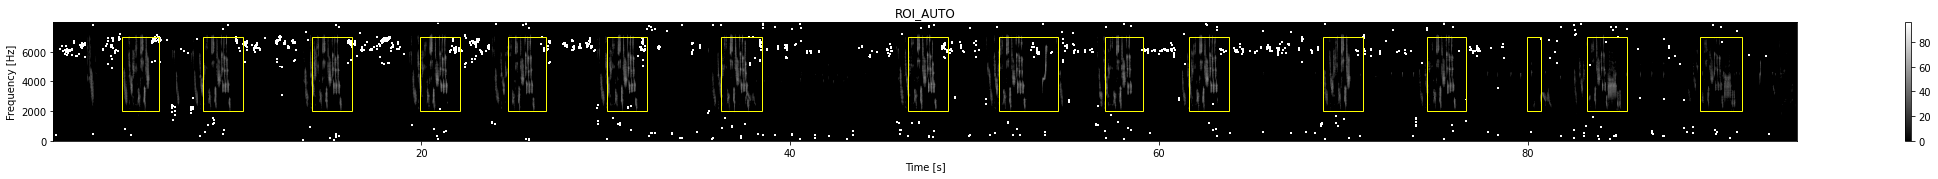

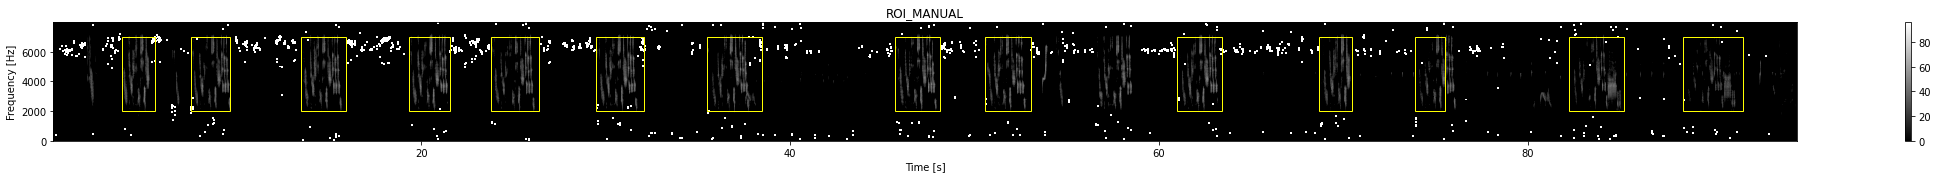

In [ ]:
ROIS_comparation(slices,'XC72437')

In [ ]:
#orden de las filas en el dataframe de cada id

indices_ovalle={'XC101308':[0,2,3,4,5,6,7,8,9,10,11,1],
                'XC101427':[1,2,3,4,5,7,0,6,8],
                'XC116490':[0,1,2,5,6,7,3,4],
                'XC129082':[0,1,2,3,4,6,5],
                'XC206066':[0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,10],
                'XC32469':[0,1,3,5,2,4],
                'XC381073':[0,1,2,3,4,5,7,8,9,10,11,12,13,16,6,14,15,17],
                'XC618314':[0,1,2,3,4,5,6,7,8,9,15,16,17,18,19,10,11,12,13,14],
                'XC618327':[0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,10],
                'XC651146':[1,2,3,4,5,6,7,8,9,10,0],

                'XC190041':[0,1,4,5,6,7,8,11,14,15,16,17,18,19,20,21,22,23,2,3,9,10,12,13],
                'XC128910':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29],
                'XC72437':[0,1,2,3,4,5,6,9,7,8,10,11,12,14,15,13],
                'XC701134':[0,2,3,6,7,11,12,13,14,15,26,27,29,30,31,1,4,5,8,9,10,16,17,18,19,20,21,22,23,24,25,28],
                'XC127867':[1,2,3,4,5,6,10,11,12,13,14,15,16,17,0,7,8,9],
                'XC42003':[0,1,2,3,4,5,6,10,11,12,14,15,7,8,9,13],
                'XC67466':[0,1,2,3,4,5,6,7,8,9,10,11,12,13],
                'XC701136':[11,12,13,15,16,17,18,19,20,21,0,1,2,3,4,5,6,7,8,9,10,14],
                'XC336409':[0,1,3,4,5,6,7,8,9,2],
                'XC170825':[3,4,5,6,8,9,10,13,0,1,2,7,11,12],
                'XC276593':[0,1,2,3,4,6,8,5,7],
                'XC106555':[0,1,3,4,5,6,2,7],
                'XC108652':[0,3,4,6,8,9,1,2,5,7],
                'XC259363':[0,2,3,4,5,1],
                'XC236219':[0,2,3,1],
                'XC82446':[1,3,0,2],
                'XC147537':[0,1,2]}


In [ ]:
ovalle_slices_px_manual_auto=slices

In [ ]:
#aqui arreglo todo los dataframes con los indices en su lugar
for i in list(indices_ovalle.keys()):
  ovalle_slices_px_manual_auto[i]['manual'].set_axis(indices_ovalle[i], axis=0, inplace=True)
  ovalle_slices_px_manual_auto[i]['manual']=ovalle_slices_px_manual_auto[i]['manual'].sort_index()
  ovalle_slices_px_manual_auto[i]['manual'].reset_index(drop=True)

In [ ]:
#aqui creo un diccionario con las coordenadas de cada caja en una lista
ovalle={}

for i in id_manual:
  ovalle[i]={}

contador=0

for i in id_manual:

  manual=ovalle_slices_px_manual_auto[i]['manual']
  auto=ovalle_slices_px_manual_auto[i]['auto_maad']

  loga=len(manual)
  logb=len(auto)

  recortes=max(loga,logb)

  while recortes>contador:
    m_min_y,m_min_x, m_max_y, m_max_x= manual.loc[contador,['min_y','min_x', 'max_y', 'max_x']]
    a_min_y,a_min_x, a_max_y, a_max_x= auto.loc[contador,['min_y','min_x', 'max_y', 'max_x']]
    ovalle[i].update({contador:[[m_min_y,m_min_x, m_max_y, m_max_x],[a_min_y,a_min_x, a_max_y, a_max_x]]})
    contador+=1

  contador=0

In [ ]:
#calculo del IoU para todas las cajas de cada id
IoU_ovalle2={}

contador=0
for i in ovalle.keys():
  lon=len(ovalle[i])
  temp=[]

  while lon>contador:
    ra, rb = ovalle[i][contador]
    x=round(bb_intersection_over_union_v3(ra,rb),3)
    temp.append(x)
    contador+=1

  IoU_ovalle2[i]=temp
  contador=0


In [ ]:
IoU_ovalle2.keys()

dict_keys(['XC35373', 'XC701239', 'XC35374', 'XC699116', 'XC421856', 'XC190041', 'XC568559', 'XC128910', 'XC72437', 'XC618327', 'XC618314', 'XC206066', 'XC72429', 'XC701134', 'XC127867', 'XC381073', 'XC21723', 'XC42003', 'XC67466', 'XC101308', 'XC195500', 'XC346342', 'XC582182', 'XC701136', 'XC651146', 'XC336062', 'XC451684', 'XC336409', 'XC541217', 'XC245662', 'XC170825', 'XC276593', 'XC101563', 'XC104642', 'XC603268', 'XC1641', 'XC589883', 'XC101427', 'XC116490', 'XC272885', 'XC231550', 'XC106555', 'XC129082', 'XC108652', 'XC72439', 'XC158291', 'XC82448', 'XC313652', 'XC101813', 'XC233124', 'XC250899', 'XC259363', 'XC32469', 'XC106553', 'XC103480', 'XC259361', 'XC80518', 'XC86324', 'XC236219', 'XC112710', 'XC11121', 'XC101570', 'XC105827', 'XC82446', 'XC101247', 'XC147537'])

In [ ]:
IoU_ovalle2['XC72437']

[0.889,
 0.539,
 0.659,
 0.609,
 0.564,
 0.736,
 0.734,
 0.611,
 0.452,
 0.0,
 0.648,
 0.68,
 0.368,
 0.0,
 0.636,
 0.689]

In [ ]:
temp=[]
for i in IoU_ovalle2.keys():
  x=len(IoU_ovalle2[i])
  temp.append(x)
print(f'la mayor longitud es de:{max(temp)}')


la mayor longitud es de:32


In [ ]:
print(f"De los 66 audios se aislaron {sum(temp)} vocalizaciones")

De los 66 audios se aislaron 717 vocalizaciones


In [ ]:
matriz2=[]

for i in IoU_ovalle2.keys():
  a=IoU_ovalle2[i]
  a = a + [5]*(32 - len(a))
  matriz2.append(a)

In [ ]:
y=np.array([np.array(matriz2i) for matriz2i in matriz2])
print(type(y))
print(type(y[0]))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
y_pos=y
new_y=[]
for i in np.nditer(y_pos):
  new_y.append(float(i))

In [ ]:
umbral_TP=0.5
umbral_FN=0.2

new_y2= []
for i in new_y:
  if i>=umbral_TP and i<2:
    i="TP"
  elif i>umbral_FN and i<umbral_TP:
    i="FP"
  elif i<=umbral_FN:
    i="FN"
  else:
    i="x"
  new_y2.append(i)

In [ ]:
new_y3=np.array([np.array(new_y2i) for new_y2i in new_y2])

In [ ]:
new_y3=new_y3.reshape(66,32)

### Output

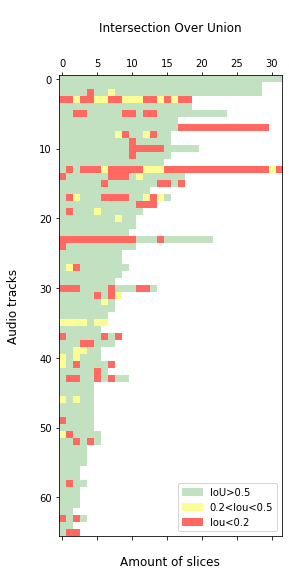

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

#figure(figsize=(25, 25), dpi=96)
#csfont = {'fontname':'Comic Sans MS'}


unique_chars, matrix = np.unique(new_y3, return_inverse=True)
color_dict = {'x': 'white', 'FN': '#ff6961', 'FP': '#FDFD96', 'TP': '#C1E1C1'}
mt=matrix.reshape(new_y3.shape)
plt.matshow(mt, cmap=ListedColormap([color_dict[char] for char in unique_chars]))
plt.title('\nIntersection Over Union\n', fontsize=12, **csfont)
plt.xlabel('\nAmount of slices',  fontsize=12, **csfont)
plt.ylabel('Audio tracks\n', fontsize=12, **csfont)

green_patch = mpatches.Patch(color='#C1E1C1', label='IoU>0.5')
yellow_patch = mpatches.Patch(color='#FDFD96', label='0.2<Iou<0.5')
red_patch = mpatches.Patch(color='#ff6961', label='Iou<0.2')
plt.legend(handles=[green_patch, yellow_patch, red_patch ],loc ="lower right")

plt.show()

In [ ]:
save_model(new_y3,"/content/drive/MyDrive/Modelos_TesisMaster/PKL/new_y3.pkl")

In [ ]:
umbral_TP=0.5
umbral_FN=0.2
TP_ovalle=0
FP_ovalle=0
FN_ovalle=0
contador=0

for i in IoU_ovalle2.keys():
  lon=len(IoU_ovalle2[i])
  while lon>contador:
    if IoU_ovalle2[i][contador]>=umbral_TP:
      TP_ovalle+=1
    elif IoU_ovalle2[i][contador]<=umbral_FN:
      FN_ovalle+=1
    else:
      FP_ovalle+=1
    contador+=1
  contador=0


print(f"""
TP_ovalle: {TP_ovalle}
FP_ovalle: {FP_ovalle}
FN_ovalle: {FN_ovalle}
""")


TP_ovalle: 552
FP_ovalle: 39
FN_ovalle: 126



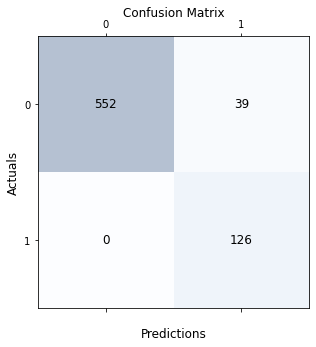

In [ ]:
array=np.array([[TP_ovalle,FP_ovalle],
 [FN_ovalle, 0]])

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(array, cmap=plt.cm.Blues, alpha=0.3)
for i in range(array.shape[0]):
    for j in range(array.shape[1]):
        ax.text(x=j, y=i,s=array[i, j], va='center', ha='center', size='xx-large', fontsize=12)

plt.xlabel('\nPredictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()

In [ ]:
save_model(IoU_ovalle2, "/content/drive/MyDrive/Modelos_TesisMaster/PKL/IoU_ovalle2.pkl")

In [ ]:
precision=TP_ovalle/(TP_ovalle+FP_ovalle)
print(f"**Precision**\nCuando se detecta un objeto, el {round(precision*100,3)}% de las veces el detector es correcto")
recall=TP_ovalle/(TP_ovalle+FN_ovalle)
print(f"**Recall**\nEl modelo detecta correctamente el {round(recall*100,3)}% de los objetos")

**Precision**
Cuando se detecta un objeto, el 93.401% de las veces el detector es correcto
**Recall**
El modelo detecta correctamente el 81.416% de los objetos


## Apply maad to all audio tracks

The X model was chosen because it has a higher precision than the Y model and therefore it will be used to segment all the audio tracks.

primero vamos a ver cuales de los tracks son cantos y cuales son llamados. Las etiquetas se revisaron y retaggearon a:

- song = el track contiene cantos
- both = el track contiene cantos y algunos llamados
- call = el track contiene en su gran mayoria llamados y unos cuantos cantos o solamente tiene llamados
- empty = el track no tiene ningun sonido o si lo tiene está muy difuso y se mezcla con el ruido ambiente

In [ ]:
df_song=database_audios[(database_audios['tipo']!='call') & (database_audios['tipo']!='empty')]

In [ ]:
x=database_audios[(database_audios['tipo']=='song')]
song=len(list(x['id_XC'].value_counts().index))

In [ ]:
print(f"""
call:{call}
empty:{empty}
song:{song}
both:{both}
Total grabaciones:{sum([call,empty,song,both])}
Total utilizables (song, both):{sum([song, both])}
Total no utilizables (call, empty):{sum([empty,call])}
""")


call:165
empty:14
song:403
both:55
Total grabaciones:637
Total utilizables (song, both):458
Total no utilizables (call, empty):179



Text(0.5, 1.0, 'Distribution of recordings according to new labels')

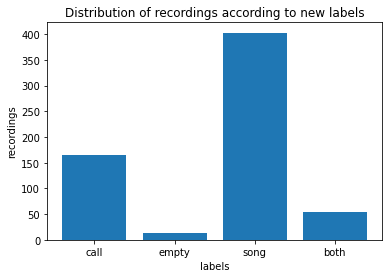

In [ ]:
plt.bar(['call','empty', 'song','both'],[call,empty,song,both])
plt.xlabel('labels')
plt.ylabel('recordings')
plt.title('Distribution of recordings according to new labels')


quedan disponibles 403 tracks con cantos y 55 tracks que contienen tanto audios como llamados. Total: 458 tracks

In [ ]:
id_song_all=list(df_song['id_XC'].value_counts().index)

In [ ]:
save_model(id_song_all, '/content/drive/MyDrive/Modelos_TesisMaster/PKL/id_song_useful.pkl' )

Encuentro los tiempos de corte

In [ ]:
# extraigo las predicciones ROI de maad y actualizo el dict
first_slices_all={}

sample_rate = 16000

for i in tqdm(id_song_all, desc='Process'):
  ROI_array=rois.find_rois_cwt(audios_procesados[i], sample_rate, flims=(2000,7000), tlen=2, th=0, display=False) #busqueda de ROI
  Sxx_power, tn, fn, ext = sound.spectrogram(audios_procesados[i], fs=sample_rate, nperseg=1024, noverlap=1024//2)

  df_sl_px= util.format_features(ROI_array, tn, fn)

  first_slices_all[i]=df_sl_px


In [ ]:
save_model(first_slices_all, "/content/drive/MyDrive/Modelos_TesisMaster/PKL/first_slices_all.pkl")

# Spectrograms

In this section, the audio clippings generated in the previous section are converted to PIL images (spectrograms)

## Experiment 1 - audios 16Khz

Primero debo convertir los tiempos de corte a indices que me permitan recortar la matriz numpy que representa el canto. Estos indices se añaden como columnas al dataframe first_slices_all

In [ ]:
sample_rate=16000
contador=0

for i in id_song_all:
  segmentos=len(first_slices_all[i])

  lista_ini=[]
  lista_fin=[]

  while segmentos>contador:
    vlr_ini=int(first_slices_all[i]['min_t'][contador]*sample_rate)
    vlr_fin=int(first_slices_all[i]['max_t'][contador]*sample_rate)

    lista_ini.append(vlr_ini)
    lista_fin.append(vlr_fin)

    contador+=1

  contador=0

  first_slices_all[i]['ini']=lista_ini
  first_slices_all[i]['fin']=lista_fin



Luego se recortan los audios

In [ ]:
audios_recortados={}

for i in id_song_all:
  audios_recortados[i]={}


contador=0

for i in id_song_all:
  segmentos=len(first_slices_all[i])

  while segmentos>contador:
    ini=first_slices_all[i]['ini'][contador]
    fin=first_slices_all[i]['fin'][contador]
    seg=audios_procesados[i][ini:fin]

    audios_recortados[i].update({contador+1:seg})

    contador+=1

  contador=0

se revisa por medio de un plot si los segmentos quedaron correctamente recortados

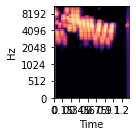

In [ ]:
from matplotlib.pyplot import figure

sample_rate = 16000
plt.figure(figsize=(2, 2))

S1 = librosa.feature.melspectrogram(y=audios_recortados['XC101308'][1], sr=sample_rate, n_mels=64)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, x_axis='time', y_axis='mel')

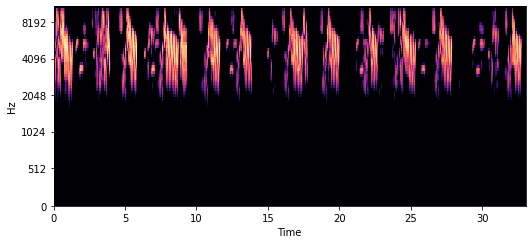

In [ ]:
S = librosa.feature.melspectrogram(audios_procesados['XC101308'], sr=sample_rate, n_mels=64)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel')

In [ ]:
#guardo el las matrices numpy (audios) recortadas
save_model(audios_recortados, "/content/drive/MyDrive/Modelos_TesisMaster/PKL/audios_recortados.pkl")

los audios ya quedaron recortados y almacenados. ahora voy a hacer unas pruebas para ver como quedaron los espectrogramas que finalmente es el output que necesito

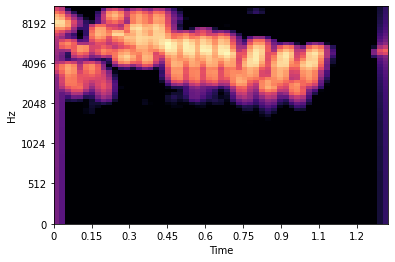

In [ ]:
s1=librosa.feature.melspectrogram(y=audios_recortados['XC101308'][1], sr=16000, n_mels=64)
s_db=librosa.power_to_db(s1, ref=96)
librosa.display.specshow(s_db,x_axis='time',y_axis='mel')

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:2099: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.dtype(np.float): np.complex,
/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:2099: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.dtype(np.float): np.complex,


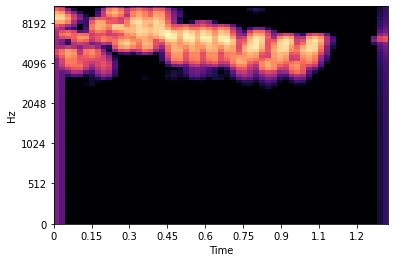

In [ ]:
s1=librosa.feature.melspectrogram(y=audios_recortados['XC101308'][1], sr=44100, n_mels=64)
s_db=librosa.power_to_db(s1, ref=96)
librosa.display.specshow(s_db,x_axis='time',y_axis='mel')

In [ ]:
import soundfile as sf

sf.write('segmento_audio_16k.wav', audios_recortados['XC101308'][1], 16000)
sf.write('segmento_audio_44k.wav', audios_recortados['XC101308'][1], 44100)

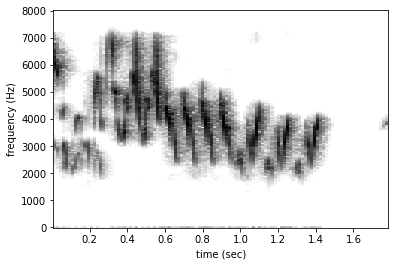

In [ ]:
audio_16k= Audio.from_file('segmento_audio_16k.wav')
spectrogram_audio16k = Spectrogram.from_audio(audio_16k)
spectrogram_audio16k.plot()

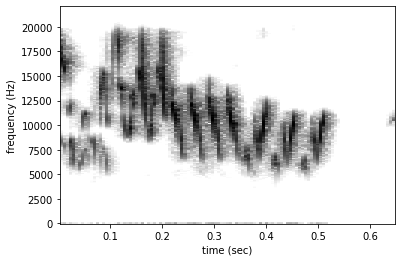

In [ ]:
audio_44k= Audio.from_file('segmento_audio_44k.wav')
spectrogram_audio44k = Spectrogram.from_audio(audio_44k)
spectrogram_audio44k.plot()

se puede ver que:

1. el espectrograma se hizo con el mismo sample rate que se ha venido trabajando (16000) sin embargo, se ve muy borroso

2. el espectrograma se trazó con (44100) y sigue viendose mal, es mas, se ve peor...quizá porque al aumentar el sample rate se dejan varios huecos en la matriz (eso creo)

convertí la matriz a audio. guardé un audio con 16k de sample rate y otro con 44k ,luego lo plotee con soundscape

1. se hizo con el audio a 16k y se ve igual de mal que con librosa

2. se hizo con el audio a 44k y se ve igual de mal que con librosa

## Experiment 2 - audios 44.1Khz

Aqui vamos a cargar los audios con una mayor frecuencia de muestreo para que su espectrograma se vea mejor.

Anteriormente cargué los audios a 16k para que el procesamiento al buscar los cortes no fuera tan complicado computacionalmente. Despues de pruebas me di cuenta de que buscar los ROIS con audios a 16k y 44k no diferia mucho en los tiempos de corte pero si en el tiempo que se llevaba el procesamiento.

Asi que, como ya tenia los tiempos de corte guardados en el diccionario (first_slices_all) lo que hice fue cargarlo y multiplicar esos tiempos por la nueva frecuencia de muestreo (44100). Esto me provee los indices en donde se debe cortar la matriz numpy que representa el audio (segun librosa).

En la siguiente sección:

- cargo y limpio audios a 44k de sample rate
- cargo los tiempos de corte y los convierto a indices
- segmento los audios y los guardo en un diccionario llamado: audios_recortados44k

In [ ]:
df_song=database_audios[(database_audios['tipo']!='call') & (database_audios['tipo']!='empty')]
id_song_all=list(df_song['id_XC'].value_counts().index)

para acelerar el proceso, el siguiente chunk se encarga de cargar el audio, convertir los tiempos de corte en indices y segmentar el audio

In [ ]:
#con este chunk puedo hacer todo el procesamiento de los audios con sample rate 44100
start=time.time()

#cargar el audio y limpiarlo
sample_rate = 44100

audios_Nonoise44k={}

for i in tqdm(id_song_all, desc='Progress denoise'):
  x=r"/content/drive/MyDrive/Modelos_TesisMaster/Tracks/Troglodytes_aedon_wav/"+i+"_Troglodytes_aedon.wav"
  s, fs = librosa.load(x, mono=True, sr=sample_rate, offset=0) #con esto ya queda remuestreado a 44k y convertido en mono
  s_filter = maad.sound.select_bandwidth(s,fs,fcut=(2000,7000), forder=5, fname ='butter', ftype='bandpass') # filtro para eliminar frecuencias y dejar solo desde 2KHz a 7KHz
  s_filter_float32=np.array(s_filter, dtype=np.float32) #cambio el tipo de dato a float32
  s_Nonoise=nr.reduce_noise(y=s_filter_float32, sr=fs) #aplico reduccion de ruido
  audios_Nonoise44k[i]=s_Nonoise

#convertir los slices de tiempo a indices de matriz

contador1=0

for j in id_song_all:
  segmentos=len(first_slices_all[j])

  lista_ini=[]
  lista_fin=[]

  while segmentos>contador1:
    vlr_ini=int(first_slices_all[j]['min_t'][contador1]*sample_rate)
    vlr_fin=int(first_slices_all[j]['max_t'][contador1]*sample_rate)

    lista_ini.append(vlr_ini)
    lista_fin.append(vlr_fin)

    contador1+=1

  contador1=0

  first_slices_all[j]['ini']=lista_ini
  first_slices_all[j]['fin']=lista_fin

#recortar los audios

audios_recortados44k={}

for k in id_song_all:
  audios_recortados44k[k]={}


contador2=0

for l in id_song_all:
  segmentos=len(first_slices_all[l])

  while segmentos>contador2:
    ini=first_slices_all[l]['ini'][contador2]
    fin=first_slices_all[l]['fin'][contador2]
    seg=audios_Nonoise44k[l][ini:fin]

    audios_recortados44k[l].update({contador2+1:seg})

    contador2+=1

  contador2=0

end = time.time()
print(end-start)


Progress denoise: 100%|██████████| 458/458 [21:33<00:00,  2.82s/it]


1293.8930230140686


In [ ]:
save_model(audios_recortados44k, "/content/drive/MyDrive/Modelos_TesisMaster/PKL/audios_recortados44k.pkl")

Decidí hacer el remuestreo a 44100 dado que la mayoria de los audios tienen originalmente esa frecuencia de muestreo. Muy pocos tienen una frecuencia menor y haciendo pruebas me di cuenta de que no afecta el remuestreo a un sample rate mas alto.

In [ ]:
mayores_44=0
iguales_44=0
menores_44=0

for i in id_song_all:
  x=r"/content/drive/MyDrive/Modelos_TesisMaster/Tracks/Troglodytes_aedon_wav/"+i+"_Troglodytes_aedon.wav"
  y=librosa.get_samplerate(x)
  if y<44100:
    menores_44+=1
  elif y>44100:
    mayores_44+=1
  else:
    iguales_44+=1

print(f'mayores a 44100: {mayores_44}')
print(f'iguales a 44100: {iguales_44}')
print(f'menores a 44100: {menores_44}')

mayores a 44100: 128
iguales a 44100: 323
menores a 44100: 7


Vamos a probar la segmentacion ploteando algunos segmentos

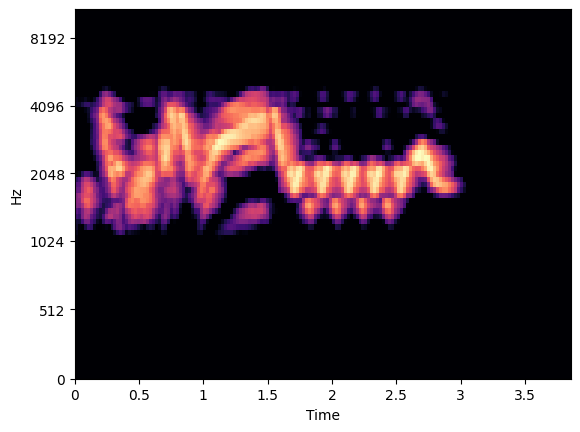

In [ ]:
s1=librosa.feature.melspectrogram(y=audios_recortados44k['XC1443'][1], sr=44100, n_mels=64)
s_db=librosa.power_to_db(s1, ref=np.max)
librosa.display.specshow(s_db,x_axis='time',y_axis='mel')

está mejor aunque no sé porque baja el canto en el eje de la frecuencia

In [ ]:
sf.write('segmento_audio_resample44k.wav',audios_recortados44k['XC1443'][1],44100)

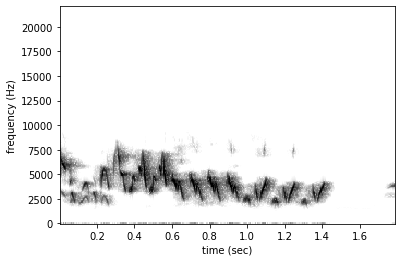

In [ ]:
audio_resample44k=Audio.from_file('segmento_audio_resample44k.wav')
audio_resample44k_spec=Spectrogram.from_audio(audio_resample44k)
audio_resample44k_spec.plot()

este es el mejor espectrograma que he logrado y me hizo caer en cuenta que es el unico que tiene el eje de frecuencia de manera correcta. lo demas tienen el eje mal

## Spectrograms 44k

Lastimosamente no encontré como mejorar los espectrogramas que provee librosa, siempre terminan viendose muy pixelados por mas de que mueva parametros, por lo que debo cambiar de paquete a uno llamado OpenSoundscape que provee una forma sencilla y rapida de generar buenos espectrogramas y exportarlos a gran resolucion.

Sin embargo, lo malo es que la libreria solo lee archivos de audio (mp3, wav, etc) pero no lee matrices numpy, por lo que debo primero que todo convertir las matrices a audio, exportar los audios al directorio y luego volver a subirlos pero desde OpenSoundscape.

En la siguiente sección:

- conversión de matrices a audios y posterior almacenamiento en el directorio
- carga de audios
- generacion de espectrogramas como imagen PIL
- almacenamiento de los espectrogramas en un diccionario y posterior exportación al directorio

primero convertimos todas las matrices numpy que hemos procesado y recortado anteriormente con librosa a audios .wav y los guardamos en un directorio

In [ ]:
path_recortes=r"/content/drive/MyDrive/Modelos_TesisMaster/First_Slices/"
contador=1
for i in tqdm(id_song_all, desc="Conversion_to_audio"):
  segmentos=len(audios_recortados44k[i])
  while segmentos>=contador:
    nombre=path_recortes+i+'_'+str(contador)+'.wav'
    sf.write(nombre, audios_recortados44k[i][contador], 44100)
    contador+=1
  contador=1

Conversion_to_audio: 100%|██████████| 458/458 [01:22<00:00,  5.58it/s]


vemos que todo haya salido bien y que los segmentos que habian sean los mismos que se exportaron

In [ ]:
cantidad_de_segmentos=[]
for i in id_song_all:
  segmentos=len(audios_recortados44k[i])
  cantidad_de_segmentos.append(segmentos)

print(f"Se detectaron {sum(cantidad_de_segmentos)} segmentos en los {len(id_song_all)} tracks")
print(f"Se exportaron {len(os.listdir(path_recortes))} al directorio en formato .wav")


Se detectaron 4426 segmentos en los 458 tracks
Se exportaron 4426 al directorio en formato .wav


subimos de nuevo los audios pero esta vez a la libreria opensoundfile. Para que el espectrograma no salga tan grande recortamos las frecuencias a 1500-8000, de igual forma en el proceso de procesamiento habiamos borrado todo por debajo de 2000kHz y de 7000kHz para arriba por lo que no hay ningun problema.

Guardamos todas las imagenes PIL en un diccionario que puede ser cargado en cualquier otro notebook

In [ ]:
path_glob_recortes=list(glob.glob(path_recortes+"/*"))

spectrogramas44k={}
image_shape = (200,1280)

for i in tqdm(path_glob_recortes, desc='Save_Spectrogram'):
  audio=Audio.from_file(i)
  spec=Spectrogram.from_audio(audio)
  spec_band=spec.bandpass(1500,8000)
  spec_img=spec_band.to_image(shape=image_shape, invert=True)
  x=i.replace(path_recortes,'').replace(".wav",'')

  spectrogramas44k[x]=spec_img


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Save_Spectrogram: 100%|██████████| 4426/4426 [02:48<00:00, 26.30it/s]


In [ ]:
save_model(spectrogramas44k, "/content/drive/MyDrive/Modelos_TesisMaster/PKL/spectrogramas44k.pkl" )